<a href="https://colab.research.google.com/github/sgcortes/25_BathymetrySotoBarca/blob/main/v3_MLP_dataFromLocalFiles_03_2025_BATIMETRIA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estimación de la Batimetría a partir de imagen UAV multiespectral. MLP (Multilayer Perceptron)
+Cota lámina de agua 212m

---
En la hoja excel adjunta (NorteEsteProf.xlsx) y en la en el hoja OesteProf.xlsx, se tienen datos de cotas del fondo ("z") de un embalse para puntos de posiciones (campos "x" e "y"). Además hay un conjunto de valores de niveles de reflectancia (campos: "red", "green", "blue", "red_edge", "nir") y de otros índices multiespectrales ("ratiobg", "ndwi", "kwlightate","ndvibarca") que han sido calculados a partir de combinaciones de las variables de reflectancia.

El objetivo es entrenar un modelo GradientBoost (sklearn) que relacione estas variables (excepto, "fid", "x", "y", "z") con la "Profundidad" (calculada como : 212-"z"). Los datos suministrados (alrededor de 16000 mas 3000) se dividirán en 60% para entrenamiento y 20% para test y 20% para validación.
al final del entrenamiento dame las métricas del resultado obtenido para el conjunto test y el del entrenamiento y valiadción por separado. Además crea tres gráficas de valores predichos frente a valores reales para la profundad para el conjunto test y para el de entrenamiento y validación. Dibuja también una gráfica de importancia de ls variables en barras horizontales y ordeandas de mayor a menor.

## Lectura de datos

In [ ]:
# Instalar Optuna si no está instalado (ya que el entorno fue reiniciado)
!pip install optuna


In [ ]:
import pandas as pd
#from google.colab import drive
# Montar Google Drive
#drive.mount('/content/drive')

# Definir la ruta del directorio en Google Drive
#path = "/content/drive/My Drive/Colab Notebooks/03_2025_BATIMETRIA-SOTO-BARCA/"

# Leer los archivos de Excel
file_norte_este = "NorteEsteProf.xlsx"
file_oeste = "OesteProf.xlsx"

df_norte_este = pd.read_excel(file_norte_este)
df_oeste = pd.read_excel(file_oeste)

# Mostrar las primeras filas de los DataFrames para verificar la carga
df_norte_este.head(), df_oeste.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(   fid          x           y       z      red    green     blue  red_edge  \
 0    1  712494.24  4796726.24  207.96  0.00419  0.01221  0.00844   0.00681   
 1    2  712494.34  4796726.31  207.96  0.00419  0.01203  0.00851   0.00766   
 2    3  712494.44  4796726.39  207.96  0.00465  0.01248  0.00872   0.00736   
 3    4  712494.54  4796726.46  207.96  0.00430  0.01289  0.00850   0.00625   
 4    5  712494.63  4796726.54  207.96  0.00411  0.01253  0.00859   0.00640   
 
        nir  ratiobg     ndwi  kwlightate  ndvibarca  Profundidad  
 0  0.00234  0.69110  0.67889    -0.36948   -0.28401         4.04  
 1  0.00261  0.70691  0.64329    -0.34685   -0.23246         4.04  
 2  0.00355  0.69853  0.55672    -0.35878   -0.13366         4.04  
 3  0.00295  0.65972  0.62730    -0.41593   -0.18623         4.04  
 4  0.00298  0.68535  0.61522    -0.37782   -0.15914         4.04  ,
    fid          x           y       z      red    green     blue  red_edge  \
 0    1  711843.11  4796729.65  204.

In [ ]:
# Recargar librerías necesarias después del reinicio del entorno
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir las características y la variable objetivo
features = ["red", "green", "blue", "red_edge", "nir", "ratiobg", "ndwi", "kwlightate", "ndvibarca"]
target = "Profundidad"

# Unir ambos conjuntos de datos en un solo DataFrame
df_total = pd.concat([df_norte_este, df_oeste], ignore_index=True)

# Imputar valores nulos con la mediana de cada columna
df_total.fillna(df_total.median(), inplace=True)

# Separar en variables independientes (X) y la variable objetivo (y)
X = df_total[features]
y = df_total[target]

# Dividir en conjunto de entrenamiento (60%), test (20%) y validación (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizar las características para mejorar la estabilidad del entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Definir la arquitectura de la red neuronal
mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=1000,
                         random_state=42)

# Entrenar la red neuronal
mlp_model.fit(X_train_scaled, y_train)

# Realizar predicciones con la red entrenada
y_train_pred_mlp = mlp_model.predict(X_train_scaled)
y_test_pred_mlp = mlp_model.predict(X_test_scaled)
y_val_pred_mlp = mlp_model.predict(X_val_scaled)

# Calcular métricas para el modelo MLP
metrics_train_mlp = {
    "MAE": mean_absolute_error(y_train, y_train_pred_mlp),
    "MSE": mean_squared_error(y_train, y_train_pred_mlp),
    "RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred_mlp)),
    "R²": r2_score(y_train, y_train_pred_mlp)
}

metrics_test_mlp = {
    "MAE": mean_absolute_error(y_test, y_test_pred_mlp),
    "MSE": mean_squared_error(y_test, y_test_pred_mlp),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred_mlp)),
    "R²": r2_score(y_test, y_test_pred_mlp)
}

metrics_val_mlp = {
    "MAE": mean_absolute_error(y_val, y_val_pred_mlp),
    "MSE": mean_squared_error(y_val, y_val_pred_mlp),
    "RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred_mlp)),
    "R²": r2_score(y_val, y_val_pred_mlp)
}


In [ ]:
# Mostrar métricas
print("\nTrain:\n",metrics_train_mlp, "\nTest:\n",metrics_test_mlp,"\nValidation:\n", metrics_val_mlp)



Train:
 {'MAE': 0.6361002242064399, 'MSE': 0.805368107875768, 'RMSE': 0.8974230372994488, 'R²': 0.7663531707573387} 
Test:
 {'MAE': 0.6717091791288442, 'MSE': 0.8964166971682344, 'RMSE': 0.9467928480761958, 'R²': 0.736005095053655} 
Validation:
 {'MAE': 0.6650789210135284, 'MSE': 0.8661920069754274, 'RMSE': 0.9306943681872301, 'R²': 0.753193442618816}


### Análisis:
El modelo tiene un R² ≈ 0.74 en el conjunto de test, lo que indica que la red neuronal logra explicar una buena parte de la variabilidad de la profundidad.
El rendimiento en test y validación es similar al de entrenamiento, lo que indica que el modelo no está sobreajustado.
Sin embargo, en comparación con el Gradient Boosting, el desempeño parece un poco inferior.

### Gráficos predichos vs Reales

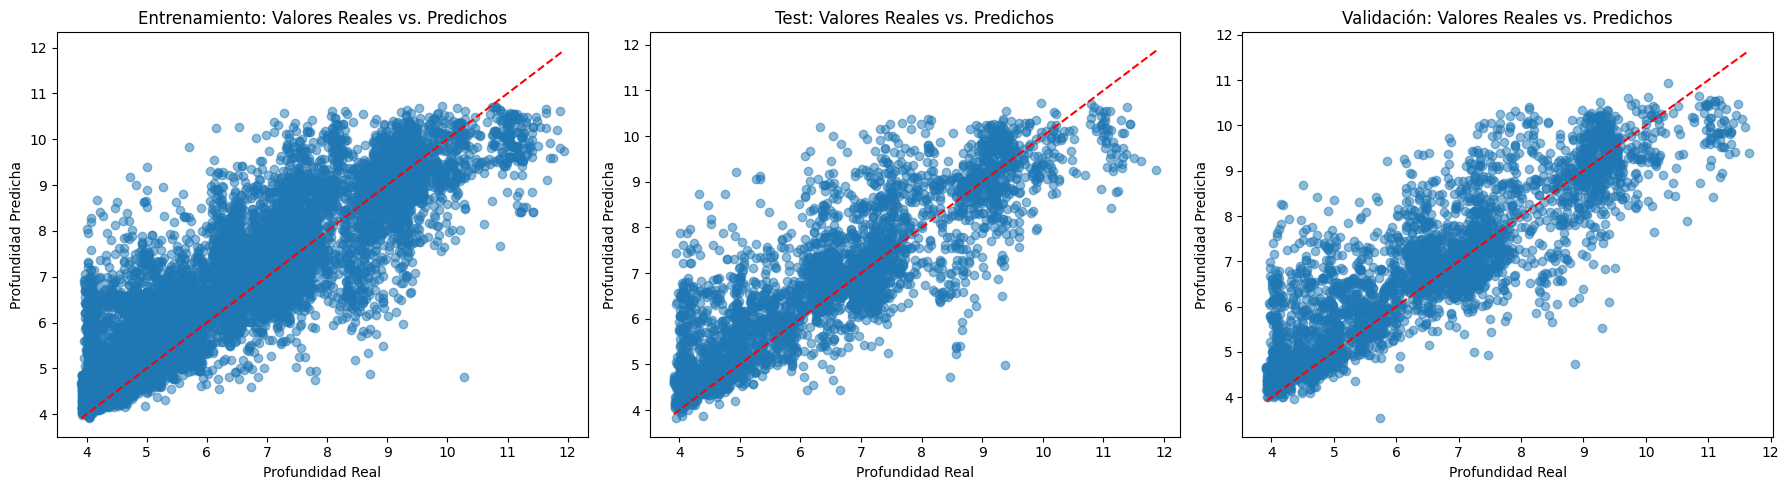

In [ ]:
import matplotlib.pyplot as plt

# Crear gráficos de valores predichos vs. valores reales
plt.figure(figsize=(18, 5))

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred_mlp, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="red", linestyle="dashed")
plt.xlabel("Profundidad Real")
plt.ylabel("Profundidad Predicha")
plt.title("Entrenamiento: Valores Reales vs. Predichos")

# Gráfico para el conjunto de test
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_mlp, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")
plt.xlabel("Profundidad Real")
plt.ylabel("Profundidad Predicha")
plt.title("Test: Valores Reales vs. Predichos")

# Gráfico para el conjunto de validación
plt.subplot(1, 3, 3)
plt.scatter(y_val, y_val_pred_mlp, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="red", linestyle="dashed")
plt.xlabel("Profundidad Real")
plt.ylabel("Profundidad Predicha")
plt.title("Validación: Valores Reales vs. Predichos")

plt.tight_layout()
plt.show()


Análisis de los gráficos:

En entrenamiento, los valores predichos siguen bastante bien la línea de identidad roja, lo que indica un buen ajuste.
En test y validación, se mantiene una tendencia similar, aunque con mayor dispersión, lo que sugiere que la red neuronal generaliza razonablemente bien.


### Importancia de las variables

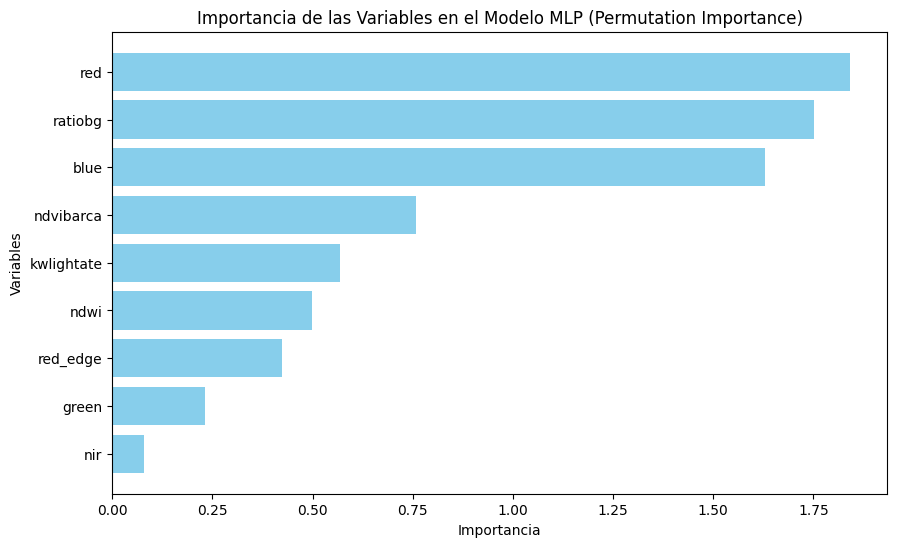

In [ ]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las variables usando Permutation Feature Importance
perm_importance = permutation_importance(mlp_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Convertir los resultados a un DataFrame
importances_df = pd.DataFrame({'Variable': features, 'Importancia': perm_importance.importances_mean})
importances_df = importances_df.sort_values(by='Importancia', ascending=True)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Variable'], importances_df['Importancia'], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.title("Importancia de las Variables en el Modelo MLP (Permutation Importance)")
plt.show()


In [ ]:

print("Training:\n",metrics_train_mlp, "\nTest:\n",metrics_test_mlp,"\nValidation:\n", metrics_val_mlp)


Training:
 {'MAE': 0.6361002242064399, 'MSE': 0.805368107875768, 'RMSE': 0.8974230372994488, 'R²': 0.7663531707573387} 
Test:
 {'MAE': 0.6717091791288442, 'MSE': 0.8964166971682344, 'RMSE': 0.9467928480761958, 'R²': 0.736005095053655} 
Validation:
 {'MAE': 0.6650789210135284, 'MSE': 0.8661920069754274, 'RMSE': 0.9306943681872301, 'R²': 0.753193442618816}


Análisis:

Algunas variables tienen una mayor influencia en la predicción de la profundidad del embalse.
Al no haber una estructura clara como en los modelos de árboles, la influencia de cada variable puede ser más distribuida y dependiente de interacciones no lineales.
Las variables con mayor importancia indican que tienen una mayor contribución a la precisión del modelo.

### Guardado del mejor modelo

In [ ]:
import joblib

# Guardar el modelo en un archivo
joblib.dump(mlp_model, "mlp_regressor_model.pkl")
print("Modelo MLP guardado como 'mlp_regressor_model.pkl'")


Modelo MLP guardado como 'mlp_regressor_model.pkl'


### Carga del mejor modelo y prediccion

In [ ]:
# Cargar el modelo desde el archivo
loaded_mlp_model = joblib.load("mlp_regressor_model.pkl")

# Usar el modelo cargado para hacer predicciones
y_pred_loaded = loaded_mlp_model.predict(X_test_scaled)

# Mostrar las primeras 5 predicciones
print("Predicciones con el modelo cargado:", y_pred_loaded[:5])

Predicciones con el modelo cargado: [6.69207655 9.20738909 4.87743478 5.83899331 6.3032222 ]


### Conjunto de datos

El grupo de datos completamente independiente, que no ha intervenido en ningún momento en el entrenamiento ni en la optimización de hiperparámetros, es el conjunto de **test**.

**Entrenamiento (60%):**

Se usó para ajustar el modelo tanto en la versión inicial como en la versión optimizada con Optuna.
Participó en la estimación de los mejores valores de los hiperparámetros.

**Validación (20%):**

Se usó en Optuna para evaluar los diferentes modelos mientras se ajustaban los hiperparámetros.
Se utilizó en el cálculo del RMSE para determinar el mejor conjunto de hiperparámetros.

**Test (20%):**

No se usó en ningún momento durante el entrenamiento ni en la optimización de hiperparámetros.
Se utilizó únicamente después de obtener el mejor modelo para evaluar su capacidad de generalización en datos completamente nuevos.

## MEJORA DE LA RED NEURONAL
### Optimización con Optuna
¿Qué vamos a optimizar?
1. Número de capas ocultas (entre 1 y 4 capas).
2. Número de neuronas por capa (entre 32 y 512).
3. Tasa de regularización alpha (para evitar sobreajuste).
4. Tipo de optimizador (adam vs sgd).
5. Número de iteraciones (max_iter).

In [ ]:
# Importar Optuna
import optuna
import optuna.visualization as vis
# Definir la función de optimización con Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    hidden_layer_1 = trial.suggest_int("hidden_layer_1", 32, 512)
    hidden_layer_2 = trial.suggest_int("hidden_layer_2", 32, 512)
    hidden_layer_3 = trial.suggest_int("hidden_layer_3", 32, 512)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1,log=True)  # Regularización L2
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    max_iter = trial.suggest_int("max_iter", 500, 2000)

    # Definir el modelo con los hiperparámetros seleccionados
    mlp_model = MLPRegressor(hidden_layer_sizes=(hidden_layer_1, hidden_layer_2, hidden_layer_3),
                             activation='relu',
                             solver=solver,
                             alpha=alpha,
                             max_iter=max_iter,
                             random_state=42)

    # Entrenar la red neuronal
    mlp_model.fit(X_train_scaled, y_train)

    # Evaluar en el conjunto de validación
    y_val_pred = mlp_model.predict(X_val_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))  # Minimizar RMSE

    return rmse

# Ejecutar la optimización con Optuna
study = optuna.create_study(direction="minimize")  # Minimizar el RMSE
study.optimize(objective, n_trials=25)  # Ejecutar 30 pruebas de hiperparámetros

# Obtener los mejores hiperparámetros encontrados
best_params_mlp = study.best_params

# 📊 Gráficos de análisis de Optuna
# 1️⃣ Optimization History Plot
fig1 = vis.plot_optimization_history(study)
fig1.show()

# 2️⃣ Importancia de los hiperparámetros
fig2 = vis.plot_param_importances(study)
fig2.show()

# 3️⃣ Slice Plot (impacto de cada hiperparámetro en RMSE)
fig3 = vis.plot_slice(study)
fig3.show()

# 4️⃣ Parallel Coordinate Plot (relación entre hiperparámetros y RMSE)
fig4 = vis.plot_parallel_coordinate(study)
fig4.show()

[I 2025-03-10 19:00:32,081] A new study created in memory with name: no-name-1c77fd08-641b-4da6-93d1-155233197981
[I 2025-03-10 19:03:59,372] Trial 0 finished with value: 0.8380207597448884 and parameters: {'hidden_layer_1': 480, 'hidden_layer_2': 208, 'hidden_layer_3': 93, 'alpha': 3.442445210932445e-05, 'solver': 'adam', 'max_iter': 1884}. Best is trial 0 with value: 0.8380207597448884.
[I 2025-03-10 19:06:43,133] Trial 1 finished with value: 0.8526103486096974 and parameters: {'hidden_layer_1': 400, 'hidden_layer_2': 187, 'hidden_layer_3': 397, 'alpha': 0.0029913214909053705, 'solver': 'adam', 'max_iter': 1778}. Best is trial 0 with value: 0.8380207597448884.
[I 2025-03-10 19:09:19,148] Trial 2 finished with value: 0.8543632454777803 and parameters: {'hidden_layer_1': 244, 'hidden_layer_2': 136, 'hidden_layer_3': 323, 'alpha': 4.89203238639898e-05, 'solver': 'adam', 'max_iter': 590}. Best is trial 0 with value: 0.8380207597448884.
[I 2025-03-10 19:12:33,115] Trial 3 finished with va

In [ ]:
# Entrenar el mejor modelo con los hiperparámetros óptimos
#best_mlp_model = MLPRegressor(**best_params_mlp, activation='relu', random_state=42)
hidden_layers = (best_params_mlp["hidden_layer_1"],
                 best_params_mlp["hidden_layer_2"],
                 best_params_mlp["hidden_layer_3"])

# Crear el modelo MLP con los mejores hiperparámetros
best_mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layers,
                              activation='relu',
                              solver=best_params_mlp["solver"],
                              alpha=best_params_mlp["alpha"],
                              max_iter=best_params_mlp["max_iter"],
                              random_state=42)

best_mlp_model.fit(X_train_scaled, y_train)

# Realizar predicciones con el mejor modelo optimizado
y_train_pred_best_mlp = best_mlp_model.predict(X_train_scaled)
y_test_pred_best_mlp = best_mlp_model.predict(X_test_scaled)
y_val_pred_best_mlp = best_mlp_model.predict(X_val_scaled)

# Calcular métricas del modelo optimizado
metrics_train_best_mlp = {
    "MAE": mean_absolute_error(y_train, y_train_pred_best_mlp),
    "MSE": mean_squared_error(y_train, y_train_pred_best_mlp),
    "RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred_best_mlp)),
    "R²": r2_score(y_train, y_train_pred_best_mlp)
}

metrics_test_best_mlp = {
    "MAE": mean_absolute_error(y_test, y_test_pred_best_mlp),
    "MSE": mean_squared_error(y_test, y_test_pred_best_mlp),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred_best_mlp)),
    "R²": r2_score(y_test, y_test_pred_best_mlp)
}

metrics_val_best_mlp = {
    "MAE": mean_absolute_error(y_val, y_val_pred_best_mlp),
    "MSE": mean_squared_error(y_val, y_val_pred_best_mlp),
    "RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred_best_mlp)),
    "R²": r2_score(y_val, y_val_pred_best_mlp)
}

# Mostrar los mejores hiperparámetros y las métricas optimizadas
print("Best Hyperpars:\n",best_params_mlp,"\nBest MLP Train:\n", metrics_train_best_mlp,"\nTest MLP Test:\n", metrics_test_best_mlp, "\nBest MLP Val:\n",metrics_val_best_mlp)


Best Hyperpars:
 {'hidden_layer_1': 480, 'hidden_layer_2': 208, 'hidden_layer_3': 93, 'alpha': 3.442445210932445e-05, 'solver': 'adam', 'max_iter': 1884} 
Best MLP Train:
 {'MAE': 0.4981704278557559, 'MSE': 0.5483369015505333, 'RMSE': 0.7404977390583534, 'R²': 0.8409209687456483} 
Test MLP Train:
 {'MAE': 0.5839171395845177, 'MSE': 0.7542180022867644, 'RMSE': 0.8684572541505796, 'R²': 0.7778826404600663} 
Best MLP Val:
 {'MAE': 0.5674892987209504, 'MSE': 0.7022787937634, 'RMSE': 0.8380207597448884, 'R²': 0.7998977016472604}


En las redes neuronales MLP (Multilayer Perceptron) no hay una métrica directa de importancia de las variables.

Para estimar la importancia de las variables en un MLP, usamos **Permutation Feature Importance**, que es una técnica basada en el impacto de cada variable en la predicción.
Proceso de cálculo:

Se calcula el RMSE original del modelo.
Se mezcla aleatoriamente una de las variables de entrada.
Se vuelve a calcular el RMSE del modelo con la variable alterada.
La importancia de la variable se define como la diferencia entre el RMSE original y el RMSE después de la permutación.
Cuanto más aumente el error al desordenar una variable, más importante es esa variable.

**¿Las importancias son relativas?**
 No son relativas ni normalizadas.
 Son valores absolutos de impacto en el error del modelo.

Si una variable tiene una importancia de 1.75, significa que al eliminar su relación con el objetivo (mezclar sus valores aleatoriamente), el error del modelo aumentó en 1.75 unidades de RMSE.

**¿Por qué "red" está por encima de 1.75?**

La variable "red" tiene un impacto fuerte en la predicción.
Si la eliminamos o la permutamos, el error del modelo aumenta significativamente.
Valores altos indican variables con mayor impacto en la predicción.
Optimization History Plot (plot_optimization_history)
📉 Muestra cómo el RMSE ha ido mejorando en cada prueba de Optuna.

Importancia de los hiperparámetros (plot_param_importances)
📊 Indica qué hiperparámetros tienen mayor impacto en el RMSE.

Slice Plot (plot_slice)
📏 Permite ver cómo varía el RMSE en función de cada hiperparámetro.

Parallel Coordinate Plot (plot_parallel_coordinate)
🔗 Muestra cómo diferentes combinaciones de hiperparámetros afectan el RMSE.
